In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.patches import Circle
import pandas as pd
# from sklearn.linear_model import LinearRegression
import glob
import xarray as xr
import cartopy.crs as ccrs
from itertools import combinations
import warnings 
warnings.filterwarnings('ignore')
import xesmf as xe
from scipy import signal
from scipy.signal import periodogram, welch
from scipy.stats import linregress
from netCDF4 import Dataset 
from osgeo import gdal
import os

# Stallite image

In [3]:
image = gdal.Open('/Users/yongyao/Downloads/S2SR_image/S2_Global_SummerAveraged_2018.tif')
print(image.RasterCount)

4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5938].


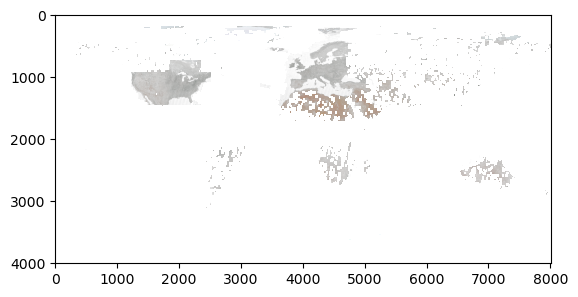

In [4]:
# Fetch the bands and Read the bands as Numpy arrays
band1 = image.GetRasterBand(1).ReadAsArray()  # B4, Red
band2 = image.GetRasterBand(2).ReadAsArray()  # B3, Green
band3 = image.GetRasterBand(3).ReadAsArray()  # B2, Blue
band4 = image.GetRasterBand(4).ReadAsArray()  # B8, NIR

# stacking the three bands (Red, Green, Blue) into a single RGB image and displaying
img = np.dstack((band1, band2, band3, band4))
f = plt.figure()
plt.imshow(img)
plt.show()

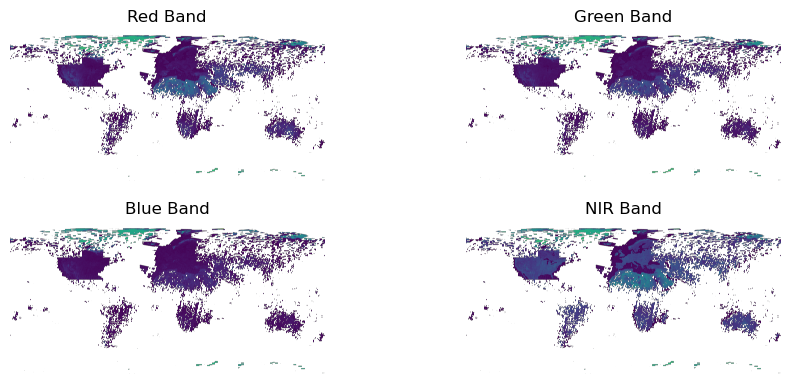

In [5]:
# Fetch and read the bands
bands = [image.GetRasterBand(i).ReadAsArray() for i in range(1, 5)]
band_names = ['Red', 'Green', 'Blue','NIR']

# Plot each band separately
plt.figure(figsize=(10, 4))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(bands[i],)
    plt.title(f'{band_names[i]} Band')
    plt.axis('off')

plt.tight_layout()
plt.show()

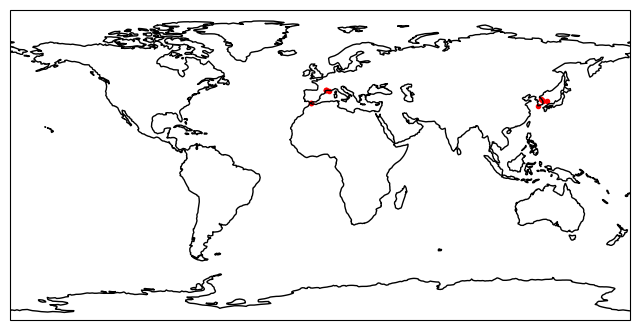

In [6]:
present=pd.read_csv('/Users/yongyao/Downloads/S2SR_image/present.csv')
absent=pd.read_csv('/Users/yongyao/Downloads/S2SR_image/absent.csv')
present_2018=present[present.year ==2018]
absent_2018=absent[absent.year ==2018]

plt.figure(figsize=(8,6))
ax= plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_global() 
ax.coastlines()
ax.scatter(present_2018['decimalLongitude'],present_2018['decimalLatitude'], 
                    transform=ccrs.PlateCarree(),
                    marker='.',c='red')
# ax.scatter(absent_2018['decimalLongitude'],absent_2018['decimalLatitude'], 
#                     transform=ccrs.PlateCarree(),
#                     marker='.',c='green')


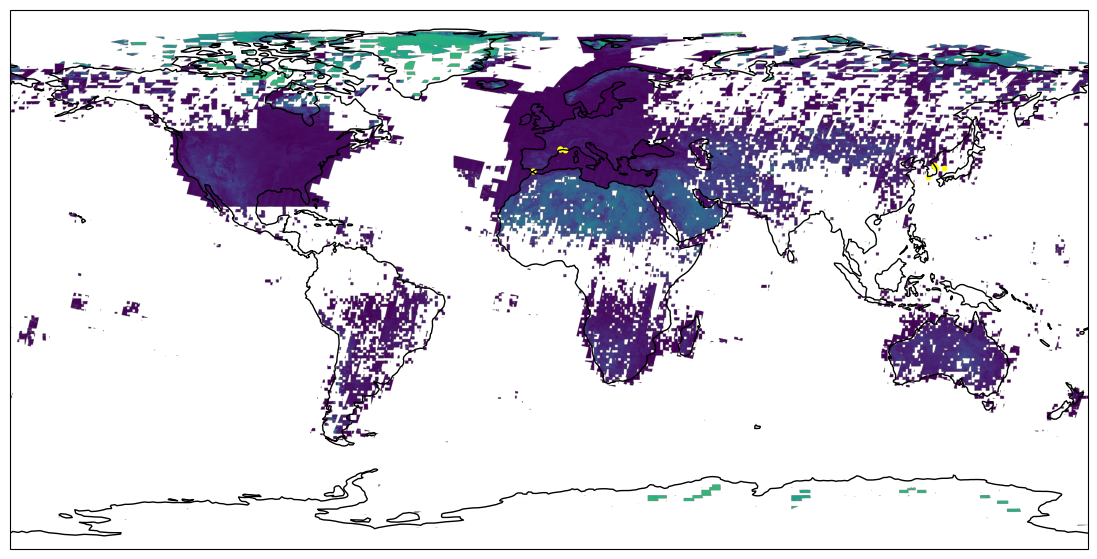

In [7]:
image = gdal.Open('/Users/yongyao/Downloads/S2SR_image/S2_Global_SummerAveraged_2018.tif')
geotransform = image.GetGeoTransform()
geotransform
# Compute extent
minx = geotransform[0]
maxy = geotransform[3]
maxx = minx + geotransform[1] * image.RasterXSize
miny = maxy + geotransform[5] * image.RasterYSize
extent = [minx, maxx, miny, maxy]

# Fetch the bands and Read the bands as Numpy arrays
band1 = image.GetRasterBand(1).ReadAsArray()  # B4, Red
band2 = image.GetRasterBand(2).ReadAsArray()  # B3, Green
band3 = image.GetRasterBand(3).ReadAsArray()  # B2, Blue
band4 = image.GetRasterBand(4).ReadAsArray()  # B8, NIR
rgb = np.dstack((band3, band2, band1))

plt.figure(figsize=(14, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.imshow(band1, extent=extent, origin='upper')

ax.coastlines()
ax.set_global()
ax.scatter(
    present_2018['decimalLongitude'], 
    present_2018['decimalLatitude'], 
    s=10, color='yellow', 
    transform=ccrs.PlateCarree())

# make it a 64*64 pixel image that has the yellow spots

In [78]:

path = glob.glob('/Users/yongyao/Downloads/S2SR_image/COPERNICUS-S3-OLCI/*.tif')
absent=pd.read_csv('/Users/yongyao/Downloads/S2SR_image/absent.csv')

# Create transformer from lat/lon to image CRS (assuming EPSG:3857)
transformer = Transformer.from_crs("epsg:4326", "epsg:3857", always_xy=True)

# Transform all points in your CSV
absent['x'], absent['y'] = transformer.transform(
    absent['decimalLongitude'].values,
    absent['decimalLatitude'].values
)

output_dir = '/Users/yongyao/Downloads/S2SR_image/patches_absent' 
os.makedirs(output_dir, exist_ok=True)

for p in path:
    img = gdal.Open(p)
    name = p.split('/')[-1]
    year = int(name.split('_')[0])
    bands = img.RasterCount
    
    geotransform = img.GetGeoTransform()
    pixel_width = geotransform[1]
    pixel_height = geotransform[5]

    minlon = geotransform[0]
    maxlat = geotransform[3]
    maxlon = minlon + pixel_width * img.RasterXSize
    minlat = maxlat + pixel_height * img.RasterYSize

    absent_subset = absent[
        (absent['year'] == year) &
        (absent['x'] >= minlon) &
        (absent['x'] < maxlon) &
        (absent['y'] >= minlat) &
        (absent['y'] < maxlat)
    ]


    for idx, (x, y) in enumerate(zip(absent_subset['x'], absent_subset['y'])):
        # Compute pixel coordinates in image CRS
        px = int((x - minlon) / pixel_width)
        py = int((y - maxlat) / pixel_height)  # pixel_height is negative for north-up images

        # Compute patch boundaries
        x_start = max(px - 32, 0)
        x_end = min(px + 32, img.RasterXSize)
        y_start = max(py - 32, 0)
        y_end = min(py + 32, img.RasterYSize)

        # Read all bands and crop patch
        img_np = np.dstack([img.GetRasterBand(i+1).ReadAsArray() for i in range(img.RasterCount)])
        patch = img_np[y_start:y_end, x_start:x_end, :]

        # Save patch as GeoTIFF
        driver = gdal.GetDriverByName('GTiff')
        out_path = os.path.join(output_dir, f"{year}_{idx}.tif")
        out_ds = driver.Create(
            out_path,
            patch.shape[1],  # width
            patch.shape[0],  # height
            patch.shape[2],  # number of bands
            gdal.GDT_Float32
        )

        # Compute new geotransform for patch
        new_geotransform = (
            minlon + x_start * pixel_width,
            pixel_width,
            0,
            maxlat + y_start * pixel_height,
            0,
            pixel_height
        )
        out_ds.SetGeoTransform(new_geotransform)
        out_ds.SetProjection(img.GetProjection())

        # Write each band
        for b in range(patch.shape[2]):
            out_ds.GetRasterBand(b+1).WriteArray(patch[:, :, b])

        out_ds.FlushCache()
        out_ds = None  # close file



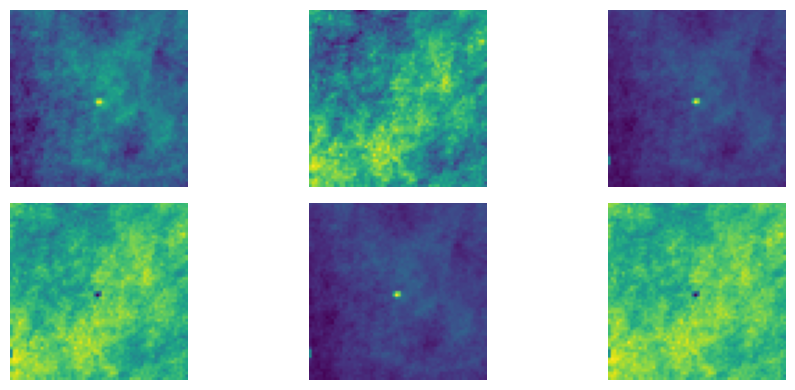

In [89]:
image = gdal.Open('/Users/yongyao/Downloads/S2SR_image/patches_present/2016_0.tif')
image

# Fetch and read the bands
bands = [image.GetRasterBand(i).ReadAsArray() for i in range(1, 6+1)]


# Plot each band separately
plt.figure(figsize=(10, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(bands[i],)
    plt.axis('off')

plt.tight_layout()
plt.show()
